In [1]:
pwd

'/data2/mito_lineage/src/vireo'

In [2]:
import os
os.chdir("/data2/mito_lineage")

In [3]:
from os.path import join, exists, dirname
from glob import glob
import pickle
import mplh.cluster_help as ch
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)

import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})

from src.external.pyvenn import venn


%load_ext autoreload
%autoreload 2
import src.utils.variant_utils as vu
from src.utils.data_io import wrap_load_mtx_df
from src.utils.variant_utils import filt_high, filt_low
from icecream import ic

0.5.6


In [4]:
INDIR = "data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/clones"
OUTDIR = "data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/merged/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn/clones/n_clones_20"
N_DONORS=2
vars_to_plot=10
sample_names="pre,post"
n_clones=20
var_thresh = 0.001
vcf_f=None

In [5]:
if vcf_f is None:
    vcf_f= join(dirname(INDIR), "cellSNP.base.vcf")

vcf=pd.read_csv(vcf_f,
                sep='\t').fillna("N")
vcf.index = vcf.apply(lambda x: str(x["POS"])+x["REF"] + ">" + x["ALT"],axis=1)
vcf.head()

,index_x,#CHROM,POS,REF,ALT,strand_correlation_x,vmr_x,n_cells_over_5_x,n_cells_over_20_x,old data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/pre/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn,index_y,strand_correlation_y,vmr_y,n_cells_over_5_y,n_cells_over_20_y,old data/processed/mttrace/TcellDupi_may17_2021/MTblacklist/post/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/filter_mgatk/vireoIn,new ID
4949A>G,49A>G,chrM,49,49A,G,0.953444,0.0305711,28,0,1,49A>G,0.933779,0.0496495,73,1,1,1
4949A>C,49A>C,chrM,49,49A,C,0.745356,0.0126086,0,0,2,49A>C,0.654654,0.0279199,1,0,3,2
5757T>A,57T>A,chrM,57,57T,A,1,0.019802,0,0,3,N,N,N,N,N,N,3
5757T>G,57T>G,chrM,57,57T,G,1,0.0288669,1,0,4,57T>G,0.94018,0.0484915,7,0,4,4
5757T>C,57T>C,chrM,57,57T,C,0.696967,0.0658239,486,7,5,57T>C,0.713713,0.0786919,1021,27,5,5


In [8]:
curr_indir=join(INDIR, f"lineage{n_clones}")

In [ ]:
#donors_indir = join(INDIR, "multiplex")
#out_f = os.path.join(OUTDIR, f"variants_violin_top{vars_to_plot}")

In [9]:
conditions = sample_names.split(",")
sample_names = {ind:val for ind,val in enumerate(sample_names.split(","))}

#if not os.path.exists(OUTDIR):
#    os.mkdir(OUTDIR)
cells_meta = pd.read_csv(join(curr_indir, "cells_meta.tsv"), sep='\t')
cells_meta=cells_meta.astype({"donor_index": "Int64", "donor": "Int64", "lineage":"Int64", "lineage_index":"Int64"})
cells_meta = cells_meta.set_index("ID")
#cells_meta.head()

In [10]:
cells_meta['donor'].unique()

<IntegerArray>
[0, 1]
Length: 2, dtype: Int64

### Load AD , DP, vcf for each clone and extract variants using filt_high (remove donor-specific) and filt_low (only variants above certain var_thresh in clone)

In [11]:
variants_d = {}
all_AF = []
for d in np.arange(N_DONORS):
    if os.path.exists(join(curr_indir, f"donor{d}_cells_meta.tsv")): 
        donor_cells = pd.read_csv(join(curr_indir, f"donor{d}_cells_meta.tsv"), sep='\t').dropna()
        for n_cl in range(n_clones):
            prefix=f"donor{d}_lineage{n_cl}"
            curr_vcf = pd.read_csv(join(curr_indir, f"{prefix}.vcf"), sep='\t')
            #ad, dp = wrap_load_mtx(curr_indir, prefix=prefix)
            try:
                # get dense matrix with 
                AF_df, DP_df = wrap_load_mtx_df(curr_indir, oth_f=False, prefix=prefix,
                             columns=('Variant', 'Cell', 'integer'), inc_af=True, as_dense=True)
                assert(AF_df.shape==DP_df.shape)
                assert(curr_vcf.shape[0] == AF_df.shape[0])
                curr_cells_meta = pd.read_csv(join(curr_indir, f"{prefix}.labels.txt")).set_index("new index")
                curr_lineage = donor_cells[donor_cells['lineage']==n_cl].sort_values("lineage_index").set_index("ID")
                assert(curr_lineage.shape[0]==AF_df.shape[1])
                AF_df.columns = curr_lineage.index

                curr_vcf.index = curr_vcf.fillna("N").apply(lambda x: str(x["POS"]) + x["REF"]+">"+x["ALT"], axis=1)
                AF_df.index=curr_vcf.index # iloc[curr_cells['lineage_index']-1].index
                AF_df = AF_df.loc[filt_high(AF_df, 0.8)]
                AF_df = AF_df.loc[filt_low(AF_df, var_thresh)]
                all_AF.append(AF_df)
                variants_d[(d,n_cl)] = AF_df.index

            except TypeError:
                print(f"No cells in donor {d} cluster {n_cl}")
    

donor0_lineage0
donor0_lineage1
donor0_lineage2
donor0_lineage3
donor0_lineage4
donor0_lineage5
donor0_lineage6
donor0_lineage7
donor0_lineage8
donor0_lineage9
donor0_lineage10
donor0_lineage11
donor0_lineage12
donor0_lineage13
donor0_lineage14
donor0_lineage15
donor0_lineage16
donor0_lineage17
donor0_lineage18
donor0_lineage19
donor1_lineage0
donor1_lineage1
donor1_lineage2
donor1_lineage3
donor1_lineage4
donor1_lineage5
donor1_lineage6
donor1_lineage7
donor1_lineage8
donor1_lineage9
donor1_lineage10
donor1_lineage11
donor1_lineage12
donor1_lineage13
donor1_lineage14
donor1_lineage15
donor1_lineage16
donor1_lineage17
donor1_lineage18
donor1_lineage19


## Concat the AF matrix, and filter cells_meta and vcf

In [12]:
all_AF_df = pd.concat(all_AF, axis=1, sort=False)
ic(cells_meta.shape)
cells_meta = cells_meta.loc[all_AF_df.columns]
ic(cells_meta.shape)

ic(vcf.shape)
variant_df = vcf.loc[all_AF_df.index]
ic(variant_df.shape)
variant_df=pd.concat((variant_df, vu.type_of_variants(variant_df.index)), axis=1)
ic(variant_df.shape)

ic| cells_meta.shape: (14763, 8)
ic| cells_meta.shape: (5224, 8)
ic| vcf.shape: (1433, 17)
ic| variant_df.shape: (1074, 17)
ic| variant_df.shape: (1074, 22)


(1074, 22)

In [13]:
from mplh.color_utils import get_colors
varType_clrs, _ = get_colors('categorical', names=variant_df['variant type'].unique()) 

#cond_ = sns.color_palette("husl", 4)
cond_clrs, _ = get_colors('categorical', names=conditions, palette='husl') 
varType_clrs

p [[0.96780 0.44127 0.53581]
 [0.59209 0.64185 0.19351]
 [0.21045 0.67731 0.64339]
 [0.64230 0.54977 0.95827]]


{'Transition': array([0.84314, 0.00000, 0.00000]),
 'Transversion': array([0.54902, 0.23529, 1.00000])}

## Break up by donor and plot

In [14]:
all_AF_df = all_AF_df.rename_axis("Cell", axis=1).rename_axis("Variant", axis=0)

In [15]:
variants_box=vu.variants_dense(all_AF_df.fillna(0), vars_to_plot, samples_d=cells_meta['condition'], donors_d=cells_meta['donor'],
                              variant_d=variant_df['variant type'], lineage_d=cells_meta['lineage'])
#variants_box

## Plots
### a. Line plot across conditions (top 50)
x = condition (ordered as first, last, middle  
y = mean AF (and variance?)  
column = donors


### b. Line plot across donors (top 50)
x=donors
y=mean af
columns=condition

### c. Transition-transversion violinplot meanAF each column is a donor


In [17]:
ic(variants_box.shape)
variants_box = variants_box.dropna() # removes the ambiguous donors
ic(variants_box.shape)

ic| variants_box.shape: (52240, 8)
ic| variants_box.shape: (52240, 8)


(52240, 8)

## 1. Plot top variants in each donor across each called clone

In [18]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

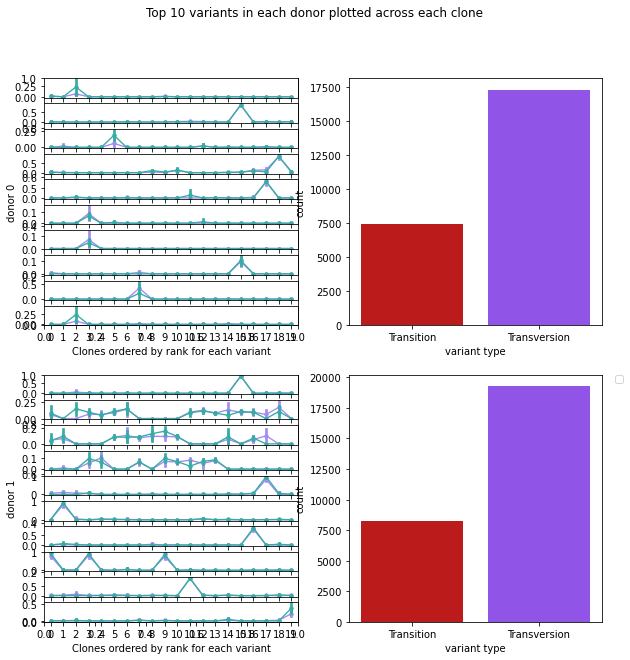

In [31]:
%matplotlib inline
f = plt.figure(figsize=(10,10))#, dpi=300)
outer = gridspec.GridSpec(N_DONORS, 2, wspace=0.2, hspace=0.2)

for d in np.arange(N_DONORS):#, df in variants_box.groupby("donor"):
    curr_cells_meta = cells_meta.loc[(cells_meta['donor']==d)]
    if len(curr_cells_meta) == 0:
        continue
    curr_AF = all_AF_df.loc[:, curr_cells_meta.index].fillna(0)
    df=vu.variants_dense(curr_AF, vars_to_plot, samples_d=curr_cells_meta['condition'], 
                                   donors_d=curr_cells_meta['donor'],
                              variant_d=variant_df['variant type'], lineage_d=curr_cells_meta['lineage'])
    curr_order = np.sort(list(set(df['lineage'].values)))
    #f,ax = plt.subplots()
    ax = plt.Subplot(f, outer[d,0])
    ax.set_ylabel(f"donor {d}")
    f.add_subplot(ax)
    inner = gridspec.GridSpecFromSubplotSpec(vars_to_plot, 1,
                    subplot_spec=outer[d,0], wspace=0.1, hspace=0.3)
    
    #ax = outer[d,1].ylabel(f"{donor})
    v_ind=0
    for v, df2 in df.groupby("Variant"):
        #curr_order = df2.groupby("lineage")["AF"].mean().argsort()[::-1].values
        #curr_order = np.sort(list(set(df2['lineage'].values)))
        ax = plt.Subplot(f, inner[v_ind])
        curr_order = np.sort(list(set(df2['lineage'].values)))
        v_ind+=1
        sns.pointplot(x='lineage', y='sqrtAF', order=curr_order, data=df2, hue="condition", palette=cond_clrs,
                      ax=ax, scale=.5, legend=False)
    
        #ax.set_visible(False)
        ax.set_ylabel("")
        ax.set_xlabel("")
        f.add_subplot(ax)
        ax.legend().set_visible(False)
    ax.set_xlabel("Clones ordered by rank for each variant")
    try:
        ax=plt.Subplot(f, outer[d,1])
        sns.countplot(x=df['variant type'], ax=ax, order=varType_clrs, 
                      palette=varType_clrs)
        f.add_subplot(ax)
    except ValueError:
        print('empty donor')

    
plt.suptitle(f"Top {vars_to_plot} variants in each donor plotted across each clone")
# handles, labels = ax.get_legend_handles_labels()
# hues = len(conditions) #len(variants_box['condition'].unique())
# l = plt.legend(handles[0:hues], labels[0:hues], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in cond_clrs.values()]
plt.legend(markers, cond_clrs.keys(), numpoints=1, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## 1.2 Plot top variants in each donor across each called clone, removing higher values

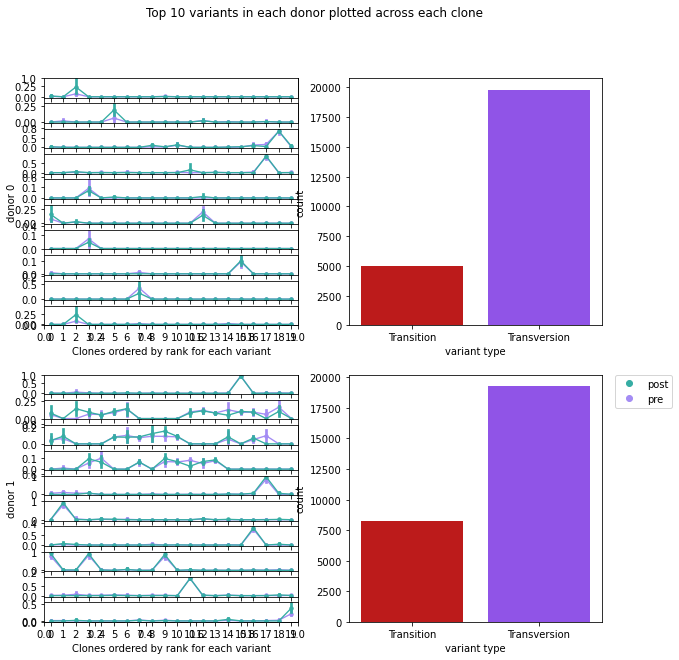

In [38]:
%matplotlib inline
f = plt.figure(figsize=(10,10))#, dpi=300)
outer = gridspec.GridSpec(N_DONORS, 2, wspace=0.2, hspace=0.2)

for d in np.arange(N_DONORS):#, df in variants_box.groupby("donor"):
    curr_cells_meta = cells_meta.loc[(cells_meta['donor']==d)]
    curr_AF = all_AF_df.loc[:, curr_cells_meta.index].fillna(0)
    curr_AF = curr_AF.loc[filt_high(curr_AF, 0.1)]
    
    df=vu.variants_dense(curr_AF, vars_to_plot, samples_d=curr_cells_meta['condition'], 
                                   donors_d=curr_cells_meta['donor'],
                              variant_d=variant_df['variant type'], lineage_d=curr_cells_meta['lineage'])
    curr_order = np.sort(list(set(df['lineage'].values)))
    ax = plt.Subplot(f, outer[d,0])
    ax.set_ylabel(f"donor {d}")
    f.add_subplot(ax)
    inner = gridspec.GridSpecFromSubplotSpec(vars_to_plot, 1,
                    subplot_spec=outer[d,0], wspace=0.1, hspace=0.3)
    #f,ax = plt.subplots()
    v_ind=0
    for v, df2 in df.groupby("Variant"):
        #curr_order = df2.groupby("lineage")["AF"].mean().argsort()[::-1].values
        #curr_order = np.sort(list(set(df2['lineage'].values)))
        ax = plt.Subplot(f, inner[v_ind])
        v_ind+=1
        sns.pointplot(x='lineage', y='sqrtAF', order=curr_order, data=df2, hue="condition", palette=cond_clrs,
                      ax=ax, scale=.5, legend=False)

        #ax.set_visible(False)
        ax.set_ylabel("")
        ax.set_xlabel("")
        f.add_subplot(ax)
        ax.legend().set_visible(False)
        
    ax.set_xlabel("Clones ordered by rank for each variant")
    try:
        ax=plt.Subplot(f, outer[d,1])
        sns.countplot(x=df['variant type'], ax=ax, order=varType_clrs, 
                      palette=varType_clrs)
        f.add_subplot(ax)
    except ValueError:
        print('empty donor')
    
plt.suptitle(f"Top {vars_to_plot} variants in each donor plotted across each clone")

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in cond_clrs.values()]
plt.legend(markers, cond_clrs.keys(), numpoints=1, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## 1.3 plot top variants of each clone

Text(0.5, 0.98, 'Top variant in each donor plotted across each clone')

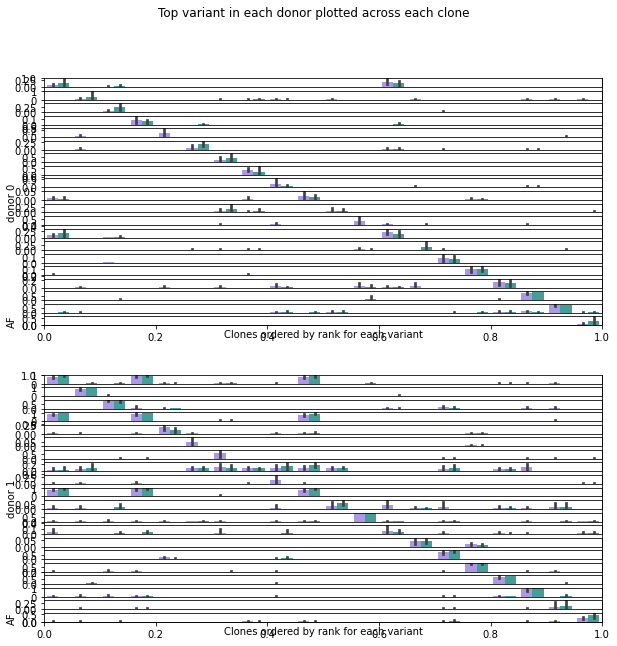

In [80]:
# %matplotlib inline
# f = plt.figure(figsize=(10,10),)#, dpi=300)
# outer = gridspec.GridSpec(N_DONORS, 1, wspace=0.2, hspace=0.2)

# for d in np.arange(N_DONORS):#, df in variants_box.groupby("donor"):
#     curr_cells_meta = cells_meta.loc[(cells_meta['donor']==d)]
#     curr_AF = all_AF_df.loc[:, curr_cells_meta.index].fillna(0)
#     curr_AF = curr_AF.loc[filt_high(curr_AF, 0.1)]
    
#     ax = plt.Subplot(f, outer[d,0])
#     ax.set_ylabel(f"donor {d}")
#     f.add_subplot(ax)
#     inner = gridspec.GridSpecFromSubplotSpec(n_clones, 1,
#                     subplot_spec=outer[d,0], wspace=0.4, hspace=0.4)
#     #f,ax = plt.subplots()
#     v_ind=0
#     all_vars = {}
    
#     for l, clone_cells_meta in curr_cells_meta.groupby("lineage"):
#         clone_cells_meta = curr_cells_meta.loc[(curr_cells_meta['lineage']==l)]
#         clone_AF = curr_AF.loc[:, clone_cells_meta.index].fillna(0)
#         df=vu.variants_dense(clone_AF, 1, samples_d=clone_cells_meta['condition'], 
#                              donors_d=clone_cells_meta['donor'], 
#                              variant_d=variant_df['variant type'], lineage_d=clone_cells_meta['lineage'])
#         curr_vars = set(df['Variant'].values)
        
#         # Take the curr variants and plot across all clones 
#         curr_AF_vars = curr_AF.loc[curr_vars]
#         curr_df_vars =vu.variants_dense(curr_AF_vars, None, samples_d=curr_cells_meta['condition'], 
#                              donors_d=curr_cells_meta['donor'], 
#                              variant_d=variant_df['variant type'], lineage_d=curr_cells_meta['lineage'])
        
#         ax = plt.Subplot(f, inner[v_ind])
        
#         v_ind+=1        
#         sns.barplot(hue="condition", y='sqrtAF', data=curr_df_vars, x="lineage", palette=cond_clrs, ax=ax)
#         ax.get_legend().remove()
#         ax.set_xticks([])
#         ax.set_xticklabels([])
#         #ax.set_yticks([])
#         ax.set_ylabel("")
#         ax.set_xlabel("")
# #         sns.pointplot(x='lineage', y='sqrtAF', data=curr_df_vars, hue="condition", palette=cond_clrs,
# #                       ax=ax, scale=.5, legend=False)
#         #ax.set_visible(False)
# #         ax.set_ylabel("")
# #         ax.set_xlabel("")
# #         ax.get_xaxis().set_visible(False)
        
#         f.add_subplot(ax)
        
#     ax.set_ylabel("AF")
#     ax.set_xlabel("Clones ordered by rank for each variant")
    
# plt.suptitle(f"Top variant in each donor plotted across each clone")

# #markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in cond_clrs.values()]
# #plt.legend(markers, cond_clrs.keys(), numpoints=1, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## 2. Plot top variants in each donor across each condition

In [ ]:
%matplotlib inline
f, ax = plt.subplots(N_DONORS, 2, figsize=(10,10))#, dpi=300)
#colors={"Transition":"green", 'Transversion': 'blue', "Undefined": 'red'}


if len(conditions) < 2:
    curr_order = conditions
else:
    curr_order = [conditions[0], conditions[-1]]+ conditions[1:-1]
for d in np.arange(N_DONORS):#, df in variants_box.groupby("donor"):
    curr_cells_meta = cells_meta.loc[(cells_meta['donor']==d)]
    curr_AF = all_AF_df.loc[:, curr_cells_meta.index].fillna(0)
    df=vu.variants_dense(curr_AF, vars_to_plot, samples_d=curr_cells_meta['condition'], 
                                   donors_d=curr_cells_meta['donor'],
                              variant_d=variant_df['variant type'], lineage_d=curr_cells_meta['lineage'])
    
    #f,ax = plt.subplots()
    for v, df2 in df.groupby("Variant"):
        #curr_order = df2.groupby("lineage")["AF"].mean().argsort()[::-1].values
        
        sns.pointplot(x='condition', y='sqrtAF', order=curr_order, data=df2,
                      ax=ax[d,0], scale=.5, legend=False, color=varType_clrs[df2["variant type"].iloc[0]])
        ax[d,0].set_xlabel(False)
    #ax[d,0].legend().set_visible(False)
    sns.countplot(data=df, x='variant type', ax=ax[d,1], hue='variant type', palette=varType_clrs,
                  order=list(varType_clrs.keys()))
    ax[d,1].legend().set_visible(False)
    
plt.suptitle(f"Top {vars_to_plot} variants in each donor across conditions")
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in varType_clrs.values()]
plt.legend(markers, varType_clrs.keys(), numpoints=1, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


#l = plt.legend(handles[0:hues], labels[0:hues], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## 2.2 Plot top variants in each donor across each condition, but removing high variants to change the scale

In [ ]:
%matplotlib inline
f, ax = plt.subplots(N_DONORS, 2, figsize=(10,10))#, dpi=300)


conditions = list(sample_names.values())

if len(conditions) < 2:
    curr_order = conditions
else:
    curr_order = [conditions[0], conditions[-1]]+ conditions[1:-1]
for d in np.arange(N_DONORS):#, df in variants_box.groupby("donor"):
    curr_cells_meta = cells_meta.loc[(cells_meta['donor']==d)]
    curr_AF = all_AF_df.loc[:, curr_cells_meta.index].fillna(0)
    curr_AF = curr_AF.loc[filt_high(curr_AF, 0.1)]
    df=vu.variants_dense(curr_AF, vars_to_plot, samples_d=curr_cells_meta['condition'], 
                                   donors_d=curr_cells_meta['donor'],
                              variant_d=variant_df['variant type'], lineage_d=curr_cells_meta['lineage'])
    
    #f,ax = plt.subplots()
    for v, df2 in df.groupby("Variant"):
        #curr_order = df2.groupby("lineage")["AF"].mean().argsort()[::-1].values
        
        sns.pointplot(x='condition', y='sqrtAF', order=curr_order, data=df2,
                      ax=ax[d,0], scale=.5, legend=False, color=varType_clrs[df2["variant type"].iloc[0]])
        #ax[d,0].set_xlabel(False)
    #ax[d,0].legend().set_visible(False)
    sns.countplot(data=df, x='variant type', ax=ax[d,1], hue='variant type', palette=varType_clrs,
                  order=list(varType_clrs.keys()))
    ax[d,1].legend().set_visible(False)
    
plt.suptitle(f"Top {vars_to_plot}  variants (<.6) in each donor across conditions")
markers = [plt.Line2D([0,0],[0,0], color=color, marker='o', linestyle='') for color in varType_clrs.values()]
plt.legend(markers, varType_clrs.keys(), numpoints=1, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


#l = plt.legend(handles[0:hues], labels[0:hues], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


## 3. Plot top variants as a column, each donor as a row, mean AF

In [ ]:
# %matplotlib inline
# #variants_box=variants_dense(AF_df, vars_to_plot)

# g = sns.catplot(x='lineage', y='sqrtAF', 
#                 hue='condition', row='donor',col='Variant', 
#                 data=variants_box, 
#                 kind="bar", dodge=True)


In [ ]:
curr_undefined = vcf.loc[set(df.loc[df["variant type"] == "Undefined"]['Variant'].values)]
curr_undefined